Setup

In [5]:
import torch
from datasets import load_dataset
from transformers import pipeline, AutoConfig, AutoModel
import ipywidgets as widgets
from IPython.display import display
import time
import math
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import math 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

%config InteractiveShell.ast_node_interactivity = 'all'
%config DisplayFormatter.float_precision = 10

Functions for Results Analysis

In [174]:
def results_table(inference_results, image_data):
    """
    Input: 
        List of results inferred from huggingface model(s)

    Output: 
        Results simplified to Pandas Table per model
    """
    res_tables = {}    
    
    # Change Format of Results to Pandas DataFrame
    for i in range(len(inference_results)):
        # Results for model i in model results list
        m_result = list(inference_results.items())[i][1]
        image_qty = len(inference_results) + 1
        
        # Reformat to Pandas DataFrame for model result i 
        res = pd.DataFrame()
        for j in range(len(m_result)):
            join = pd.DataFrame({'label': [m_result[j][1]['label']], 'score': [round(m_result[j][1]['score'], 5)]})
            res = pd.concat([res, join])
    
        # Simplify to only give 'real' probabilities 
        res = res.reset_index(drop=True)
        res['y_hat'] = np.where(res.label == 'Fake', 1 - res.score, res.score)
        res['label'] = np.where(res.label == 'Fake', 'Real', res.label)

        # Add true labels and error terms
        res['y_true'] = image_data['train'][0:image_qty]['label']
        res['error'] = abs(res['y_true'] - res['y_hat']).round(6)
        
        # Save results of model i to results table
        res_df = f'model_{i+1}_res'
        res_tables[res_df] = res

    return res_tables

def res_graphs(res):
    """
    Input: 
        List of results as a pandas dataframe
        
    Output: 
        ROC curve and confusions matricies per model
    """
    # Get optimal threshold
    fpr, tpr, threshold = metrics.roc_curve(res['y_true'], res['y_hat'])

    transform_threshold = [0] * len(threshold)
    for i in range(len(threshold)):
        transform = ([1]-fpr[i])**2 + tpr[i]**2
        transform_threshold[i] = math.sqrt(transform);  

    transform_threshold = np.array(transform_threshold);  
    max_thresh = threshold[transform_threshold.argmax(axis=0)]

    # Apply optimal threshold
    res['y_pred'] = np.where(res['y_hat'] > max_thresh, 1, 0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Roc plot
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_plot = (sns.lineplot(x=fpr, y=tpr, errorbar=None, ax=ax1, 
                                estimator=None, label='AUC='+str(round(roc_auc, 5)))
                       .set(title='ROC curve', ylabel='True Positive Rate', xlabel='False Positive Rate'));  

    # Confusion Matricies
    cm = confusion_matrix(res['y_true'], res['y_pred']);  
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', ax=ax2).set(title='Classification Quantities'); 

    cm2 = np.round(confusion_matrix(res['y_true'], res['y_pred'])/(len(res['y_pred'])/100), 2)
    sns.heatmap(cm2, annot=True, cmap='Greens', fmt='g', ax=ax3).set(title='Classification Percent of Data'); 

    # Consider Error Plot

def resize_img(images): # img.convert('RGB')
  images['image'] = [img.convert('RGB').resize((256, 256)) for img in images['image']]
  return images


Dataset Load and Preview

In [152]:
image_dt_1 = load_dataset("Whab/deepfake").shuffle(seed=12); 
image_dt_2 = load_dataset("JamieWithofs/Deepfake-and-real-images-2").shuffle(seed=12); 
image_dt_3 = load_dataset("Hemg/deepfake-and-real-images").shuffle(seed=12);  
image_dt_4 = load_dataset("thenewsupercell/new-deepfake-and-real-images").shuffle(seed=12);  

In [153]:
print('Dataset Image Dimensions:',image_dt_1['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_1.num_rows, '\n', '       Features:', image_dt_1['train'].features)
print('Dataset Image Dimensions:',image_dt_2['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_2.num_rows, '\n', '       Features:', image_dt_2['train'].features)
print('Dataset Image Dimensions:',image_dt_3['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_3.num_rows, '\n', '       Features:', image_dt_3['train'].features)
print('Dataset Image Dimensions:',image_dt_4['train'][0]['image'].size, '\n', '       Number of Images:', image_dt_4.num_rows, '\n', '       Features:', image_dt_4['train'].features)

Dataset Image Dimensions: (256, 256) 
        Number of Images: {'train': 179430} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}
Dataset Image Dimensions: (286, 256) 
        Number of Images: {'train': 3264, 'test': 1069, 'validation': 1072} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}
Dataset Image Dimensions: (256, 256) 
        Number of Images: {'train': 190335} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}
Dataset Image Dimensions: (256, 256) 
        Number of Images: {'train': 152268, 'validation': 19033, 'test': 19034} 
        Features: {'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['Fake', 'Real'], id=None)}


In [176]:
# Convert images with resize_img function
start = time.time()
image_dt_2 = image_dt_2.map(resize_img, batched=True, batch_size=256)
end = time.time() - start
print('Image Resize Time:', round(end, 2))

Map:   0%|          | 0/3264 [00:00<?, ? examples/s]

Map:   0%|          | 0/1069 [00:00<?, ? examples/s]

Map:   0%|          | 0/1072 [00:00<?, ? examples/s]

Image Resize Time: 270.7


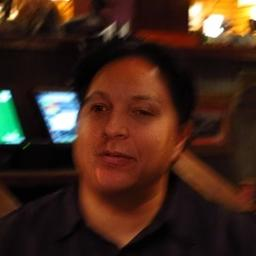

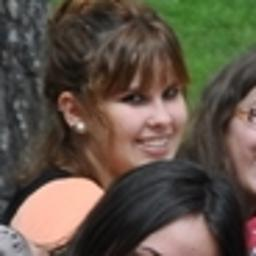

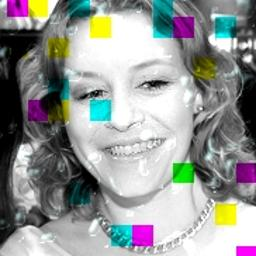

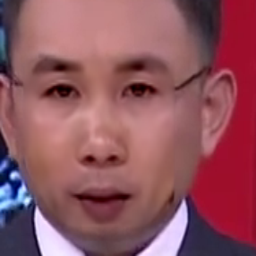

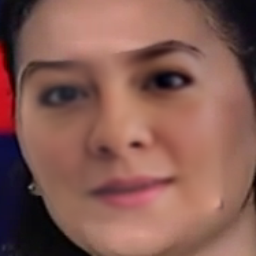

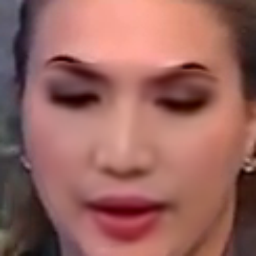

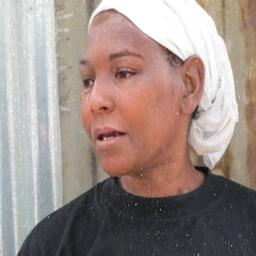

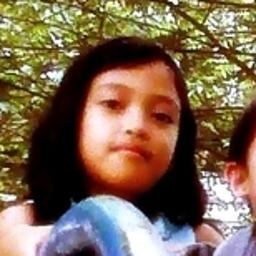

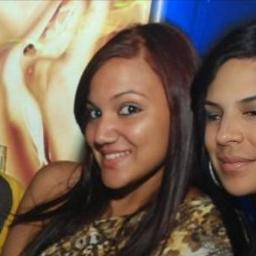

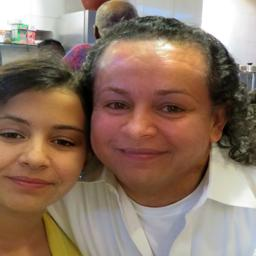

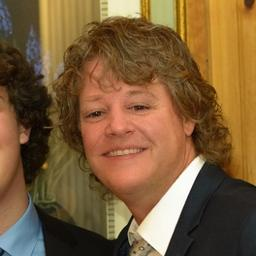

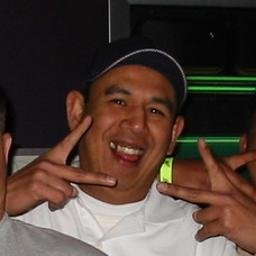

In [181]:
preview_num = 3
sample_images_1 = image_dt_1['train'][0:preview_num]
sample_images_2 = image_dt_2['train'][0:preview_num]
sample_images_3 = image_dt_3['train'][0:preview_num]
sample_images_4 = image_dt_4['train'][0:preview_num]

## Preview Images
for i in range(preview_num):
    display(sample_images_1['image'][i]) 
for i in range(preview_num):
    display(sample_images_2['image'][i])
for i in range(preview_num):
    display(sample_images_3['image'][i])
for i in range(preview_num):
    display(sample_images_4['image'][i])

Testing model quantization across 2 deepfake classifcation models

In [ ]:
%%capture
# m1 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", device='cuda', use_fast=True);  
# m1_64 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True, torch_dtype=torch.float64); 
# m2 = pipeline("image-classification", model="joyc360/deepfakes", device='cuda', use_fast=True)
# # m2_16 = pipeline("image-classification", model="joyc360/deepfakes", device='cuda', use_fast=True, torch_dtype=torch.float16) # inference time explodes
# m2_64 = pipeline("image-classification", model="joyc360/deepfakes", device='cuda', use_fast=True, torch_dtype=torch.float64) dima806/deepfake_vs_real_image_detection
# m3 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", device='cuda', use_fast=True)
# m3_16 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", device='cuda', use_fast=True, torch_dtype=torch.float16)
# m3_64 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", device='cuda', use_fast=True, torch_dtype=torch.float64)

m1 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True); 
# m1_32 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True, torch_dtype=torch.float32); 
m1_64 = pipeline("image-classification", model="prithivMLmods/Deep-Fake-Detector-Model", use_fast=True, torch_dtype=torch.float64); 
m2 = pipeline("image-classification", model="Hemg/Deepfake-Detection", use_fast=True)
m2_32 = pipeline("image-classification", model="Hemg/Deepfake-Detection", use_fast=True, torch_dtype=torch.float32)
m2_64 = pipeline("image-classification", model="Hemg/Deepfake-Detection", use_fast=True, torch_dtype=torch.float64)
m3 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", use_fast=True)
m3_32 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", use_fast=True, torch_dtype=torch.float32)
m3_64 = pipeline("image-classification", model="dima806/deepfake_vs_real_image_detection", use_fast=True, torch_dtype=torch.float64)


In [ ]:
m1 = AutoModel.from_pretrained("prithivMLmods/Deep-Fake-Detector-Model"); 

In [189]:
test1 = AutoModel.from_pretrained('prithivMLmods/Deep-Fake-Detector-Model')
test1.dtype
test2 = AutoModel.from_pretrained('Hemg/Deepfake-Detection') 
test2.dtype
test3  = AutoModel.from_pretrained('dima806/deepfake_vs_real_image_detection') 
test3.dtype

# m1.dtype
# m2.dtype
# m3.dtype

Some weights of ViTModel were not initialized from the model checkpoint at prithivMLmods/Deep-Fake-Detector-Model and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.float32

Some weights of ViTModel were not initialized from the model checkpoint at Hemg/Deepfake-Detection and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.float32

Some weights of ViTModel were not initialized from the model checkpoint at dima806/deepfake_vs_real_image_detection and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.float32

Inference by model

In [184]:
# Quantity of images to classify per dataset
image_qty = 10

# Models to compare
model_list = [m1, m1_32, m1_64, m2, m2_32, m2_64, m3, m3_32, m3_64] 
model_names = ['m1', 'm1_32', 'm1_64', 'm2', 'm2_32', 'm2_64', 'm3', 'm3_32', 'm3_64'] 

# Datasets to test
dt_list = [image_dt_1, image_dt_2, image_dt_3, image_dt_4]
dt_names = ['image_dt_1', 'image_dt_2', 'image_dt_3', 'image_dt_4']

# Initializaing results dictionaries
results_1, results_2, results_3, results_4 = {}, {}, {}, {}
res_dt_pairs = [[image_dt_1, results_1], [image_dt_2, results_2], [image_dt_3, results_3], [image_dt_4, results_4]]
# run_times = []

for k, pair in enumerate(res_dt_pairs):
    for i, model in enumerate(model_list, start=1):
        results_df = f'raw_model_{i}'
        
        start = time.time()
        pair[1][results_df] = model(pair[0]['train'][0:image_qty]['image']);  
        end = round(time.time() - start, 2)
        
        # pair[0] image dataset
        print('Dataset:', dt_names[k],'*** Model:', model_names[i-1], '*** Inference Time:', end)

Dataset: image_dt_1 *** Model: m1 *** Inference Time: 5.24
Dataset: image_dt_1 *** Model: m1_32 *** Inference Time: 4.07
Dataset: image_dt_1 *** Model: m1_64 *** Inference Time: 8.05
Dataset: image_dt_1 *** Model: m2 *** Inference Time: 3.62
Dataset: image_dt_1 *** Model: m2_32 *** Inference Time: 5.12
Dataset: image_dt_1 *** Model: m2_64 *** Inference Time: 14.35
Dataset: image_dt_1 *** Model: m3 *** Inference Time: 6.89
Dataset: image_dt_1 *** Model: m3_32 *** Inference Time: 7.88
Dataset: image_dt_1 *** Model: m3_64 *** Inference Time: 16.0
Dataset: image_dt_2 *** Model: m1 *** Inference Time: 10.06
Dataset: image_dt_2 *** Model: m1_32 *** Inference Time: 10.15
Dataset: image_dt_2 *** Model: m1_64 *** Inference Time: 19.18
Dataset: image_dt_2 *** Model: m2 *** Inference Time: 7.2
Dataset: image_dt_2 *** Model: m2_32 *** Inference Time: 6.89
Dataset: image_dt_2 *** Model: m2_64 *** Inference Time: 14.48
Dataset: image_dt_2 *** Model: m3 *** Inference Time: 6.9
Dataset: image_dt_2 ***

Create Results Tables

In [185]:
res_table_1 = results_table(results_1, image_dt_1)
res_table_2 = results_table(results_2, image_dt_2)
res_table_3 = results_table(results_3, image_dt_3)
res_table_4 = results_table(results_4, image_dt_4)


Model Results on 1st Dataset

Order of results: ['m1', 'm1_32', 'm1_64', 'm2', 'm2_32', 'm2_64', 'm3', 'm3_32', 'm3_64']


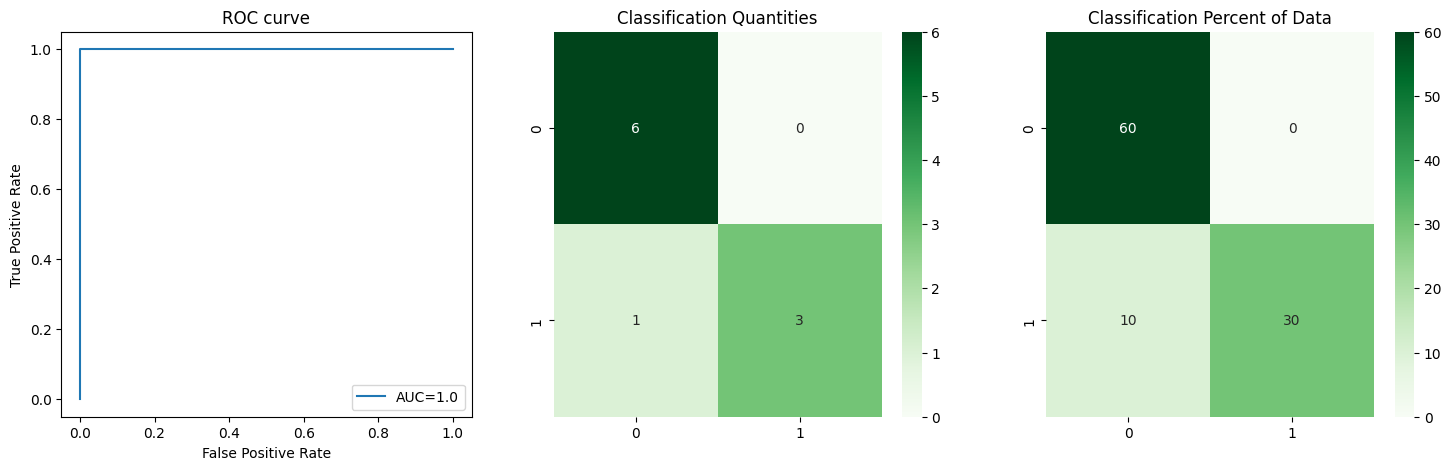

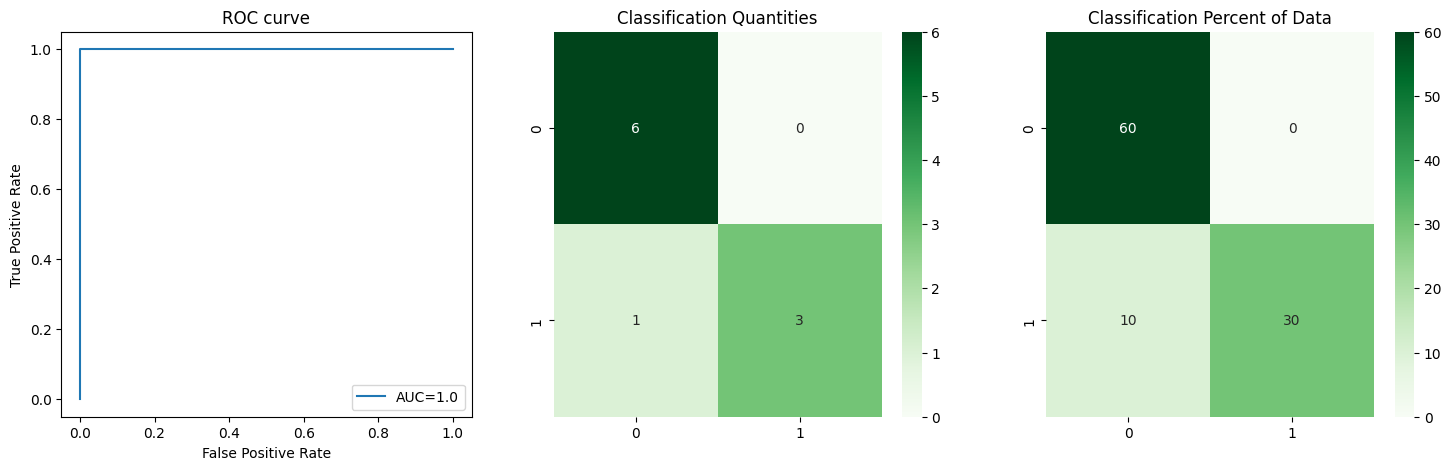

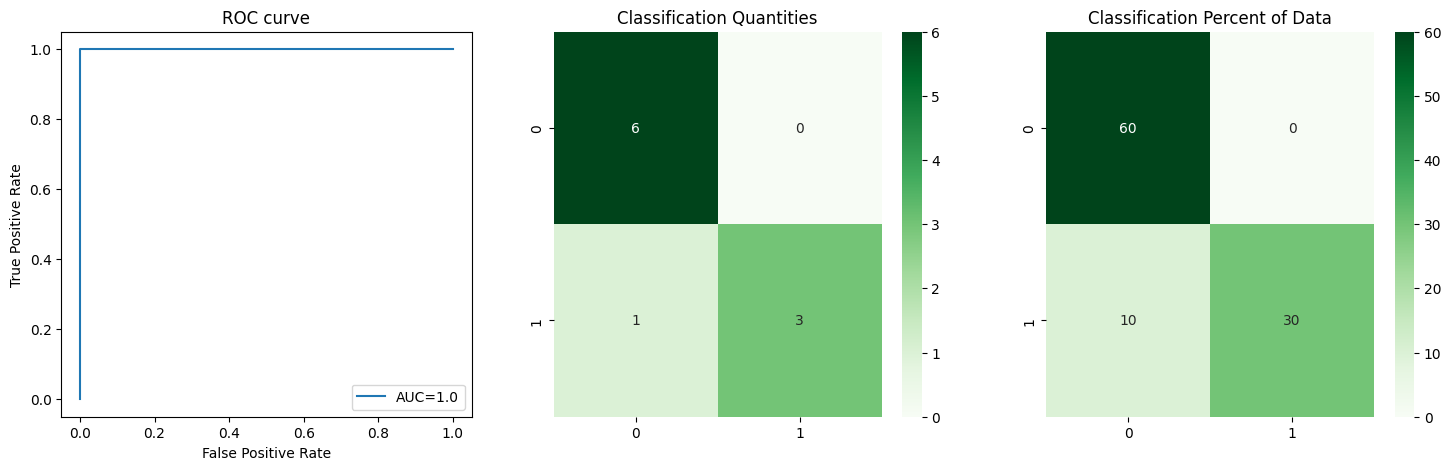

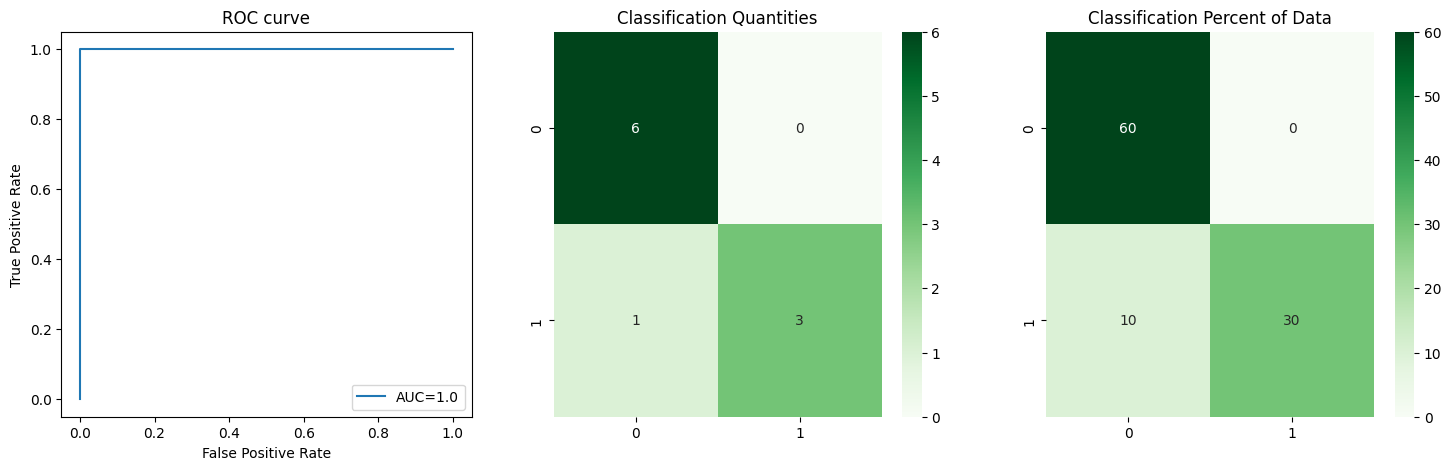

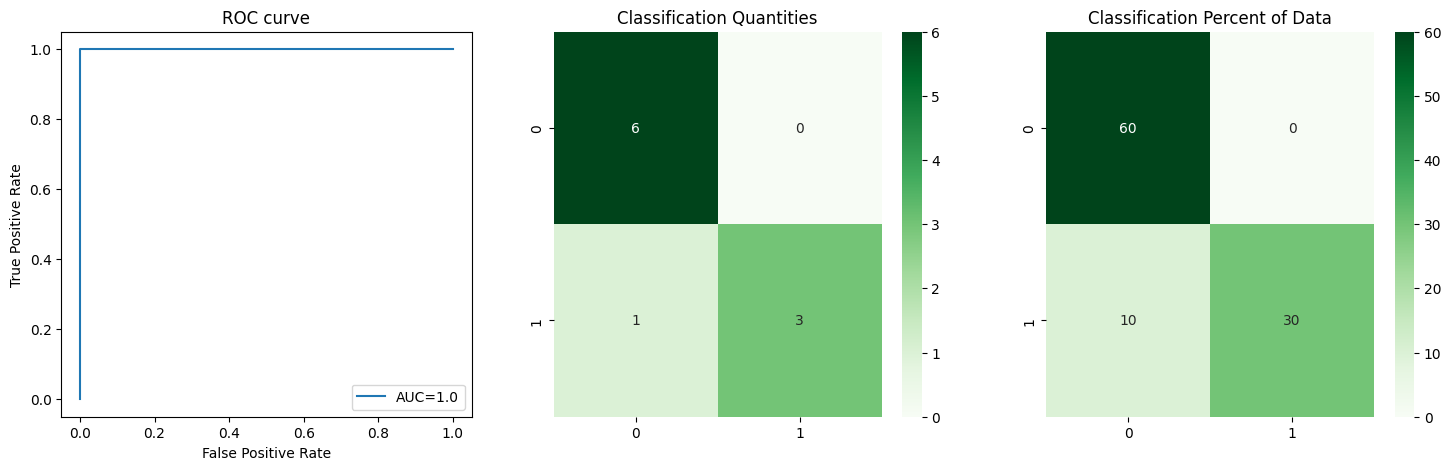

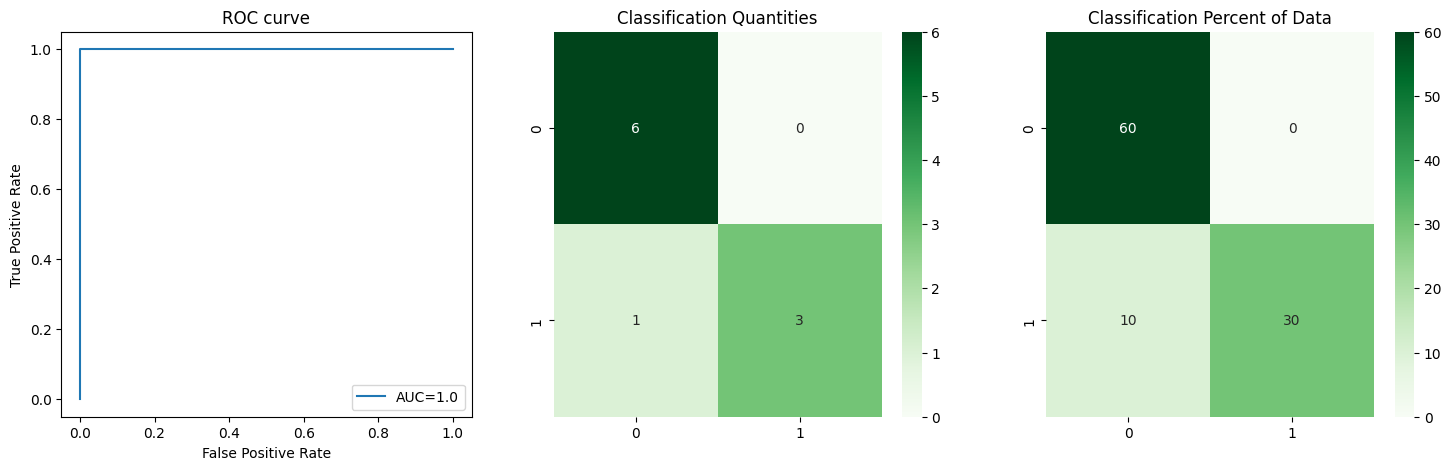

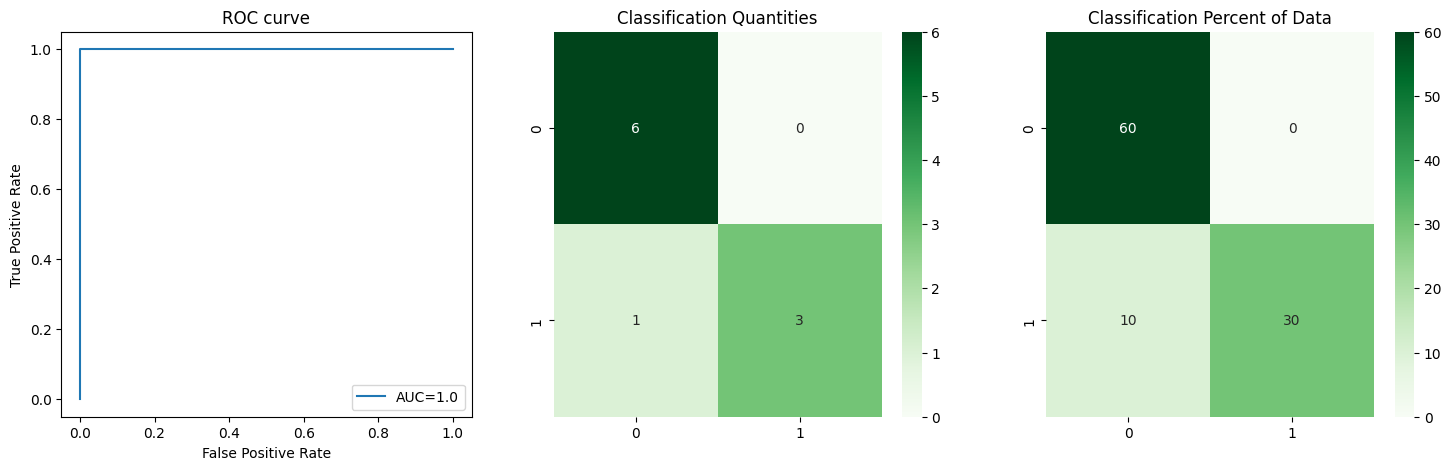

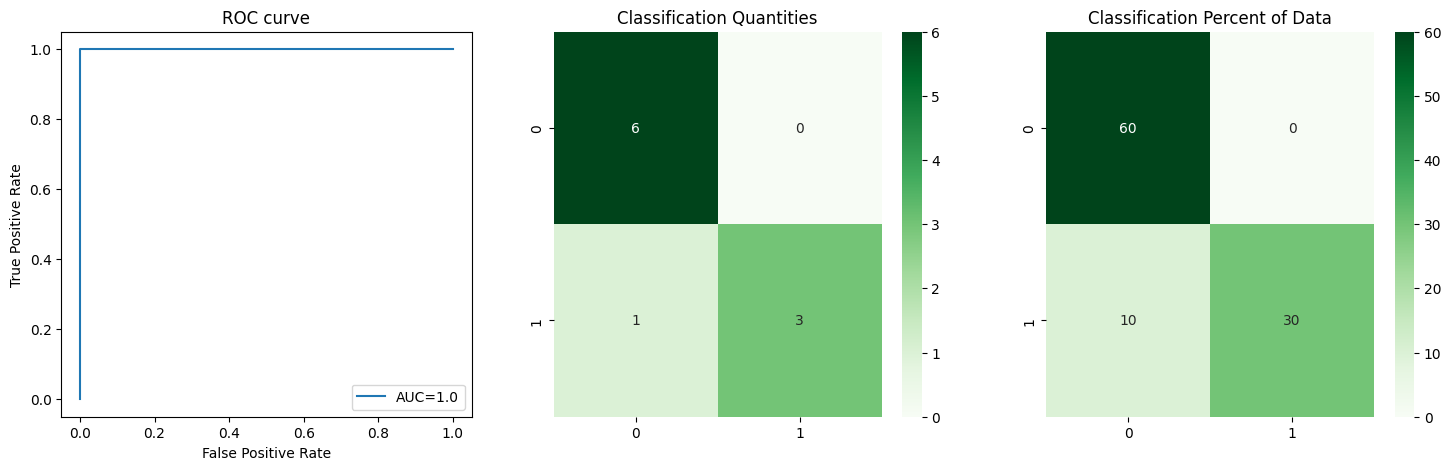

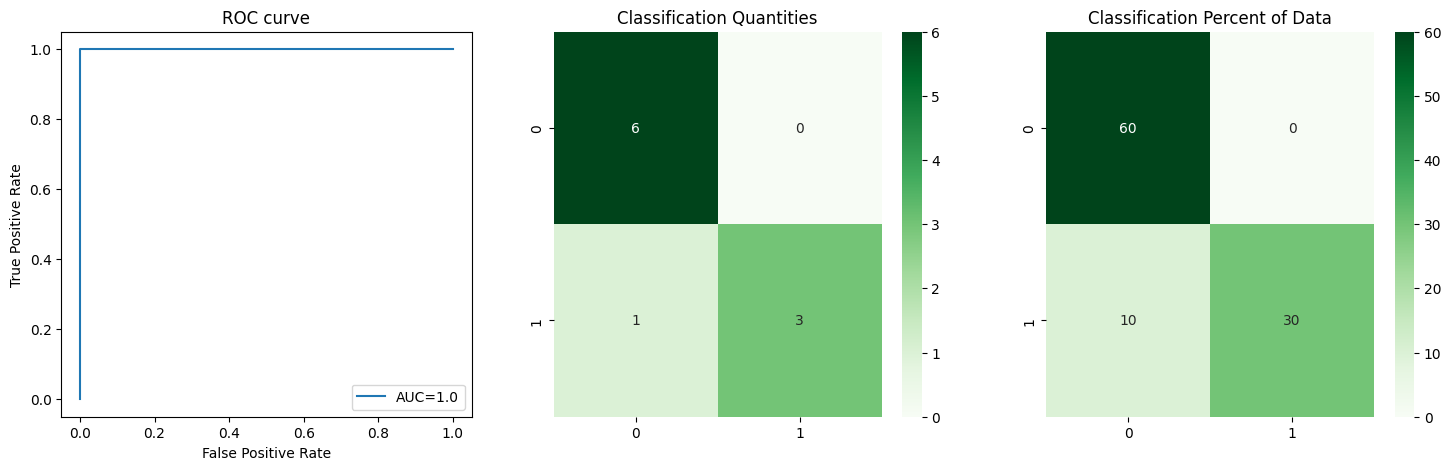

In [186]:
# Results for first dataset
print('Order of results:', model_names)
for i, tbl in enumerate(res_table_1.keys()):
    res_graphs(res_table_1[tbl])

Model Results on 2nd Dataset

Order of results: ['m1', 'm1_32', 'm1_64', 'm2', 'm2_32', 'm2_64', 'm3', 'm3_32', 'm3_64']


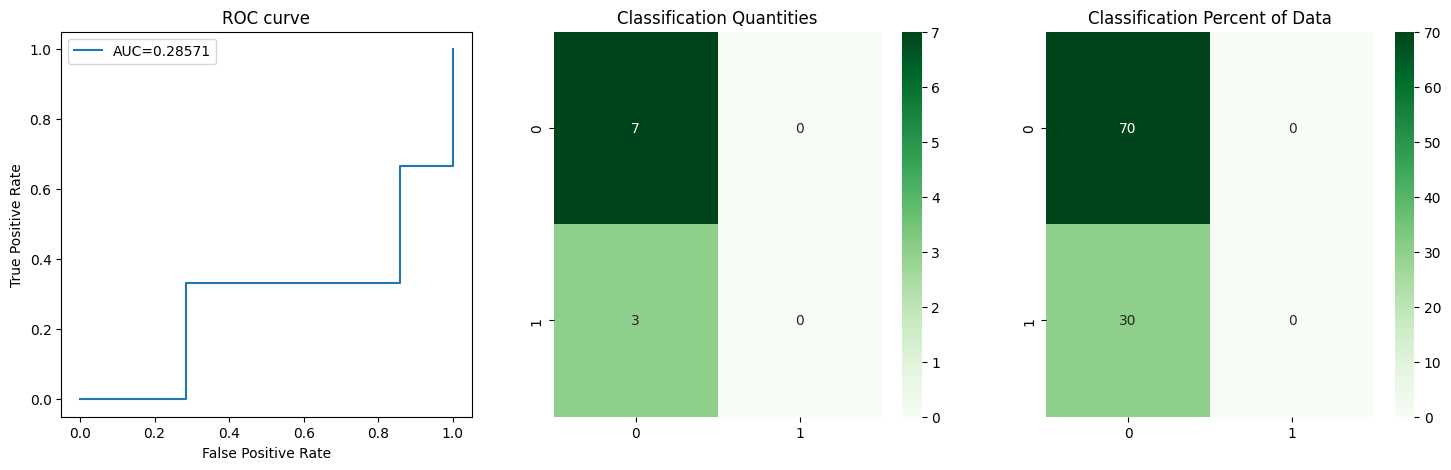

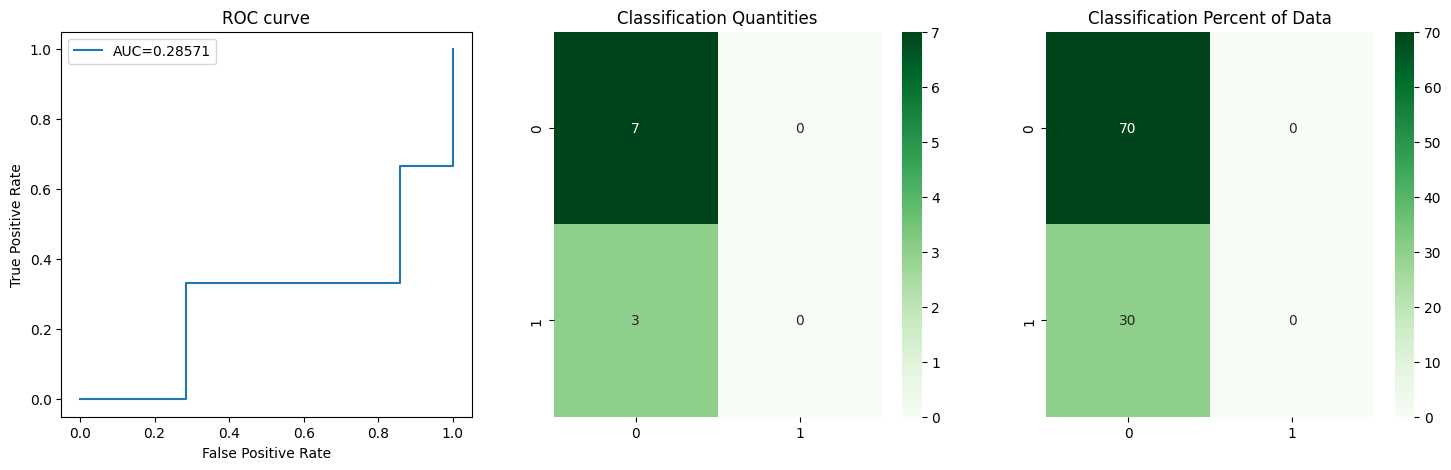

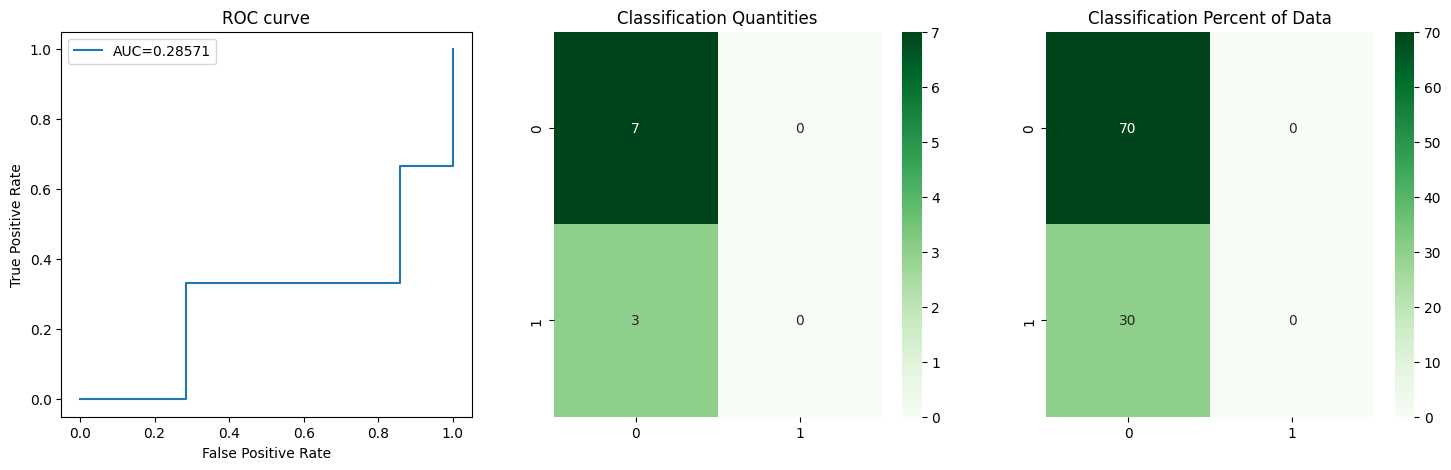

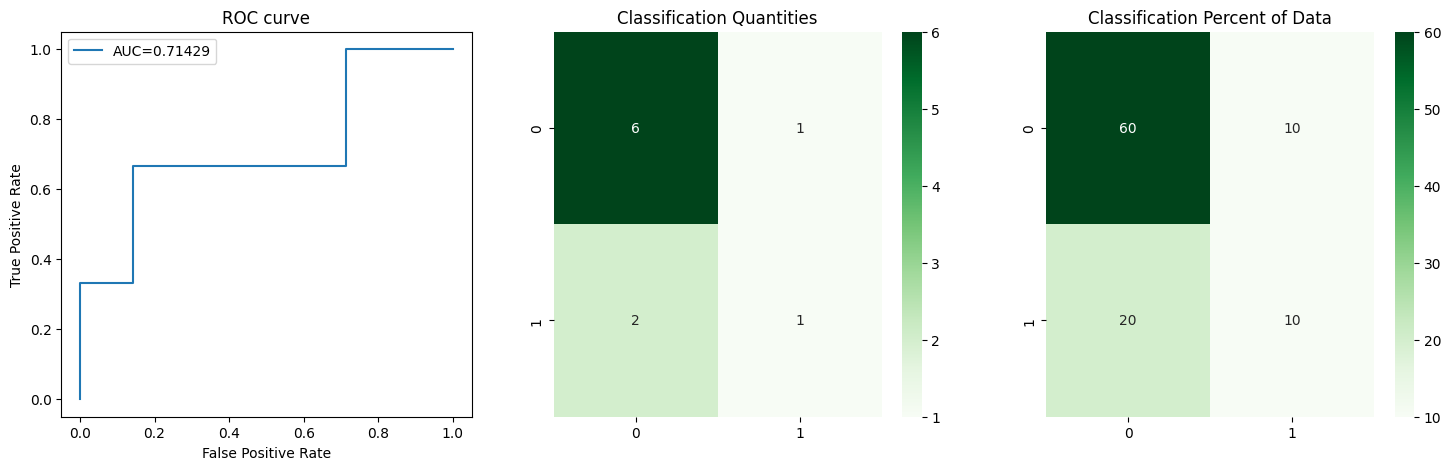

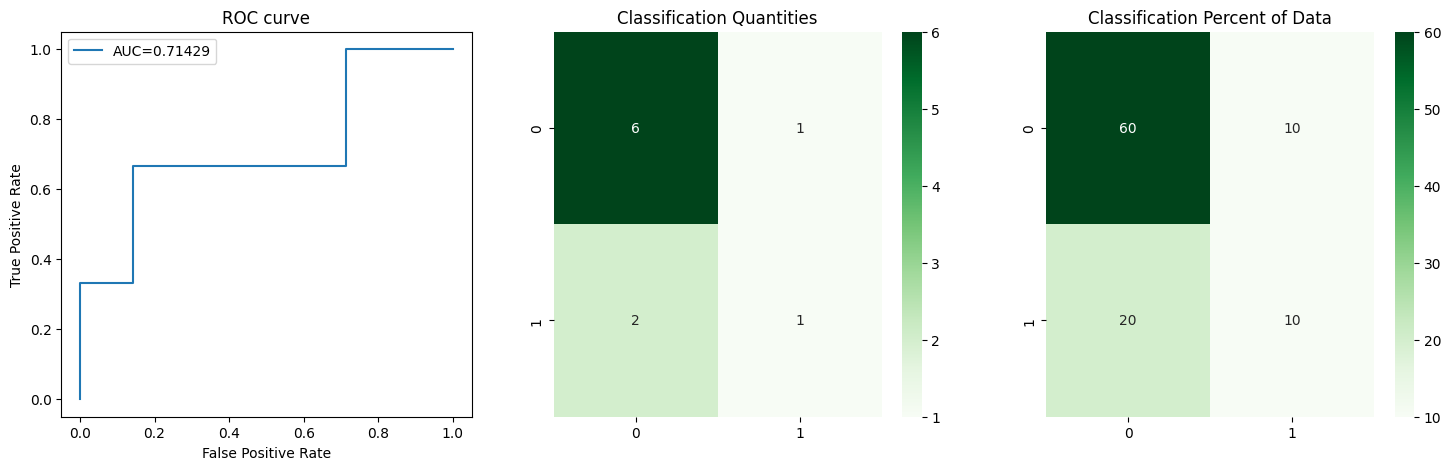

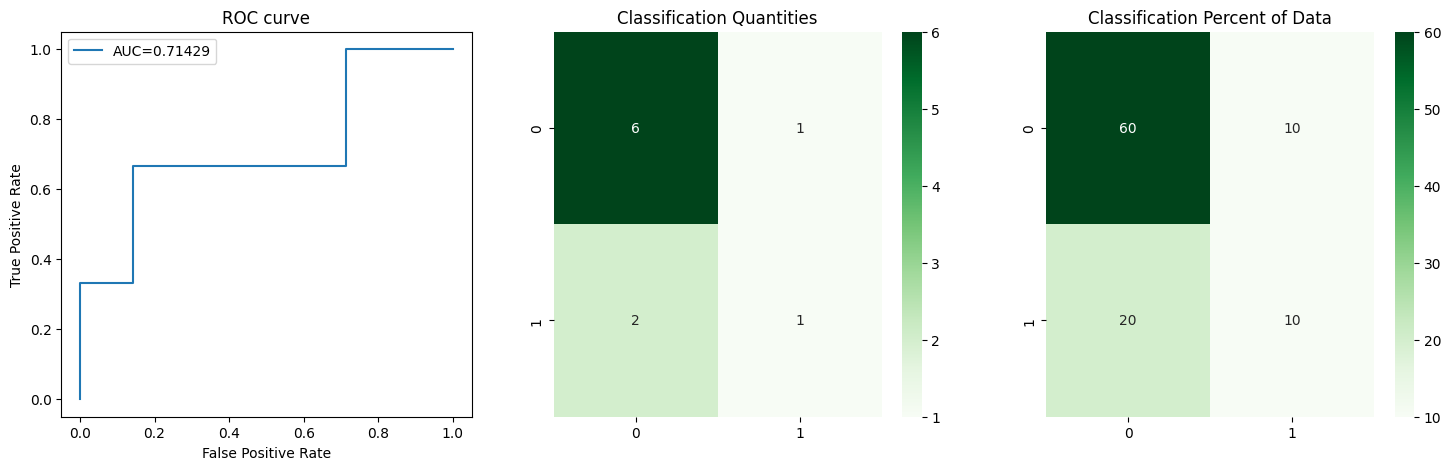

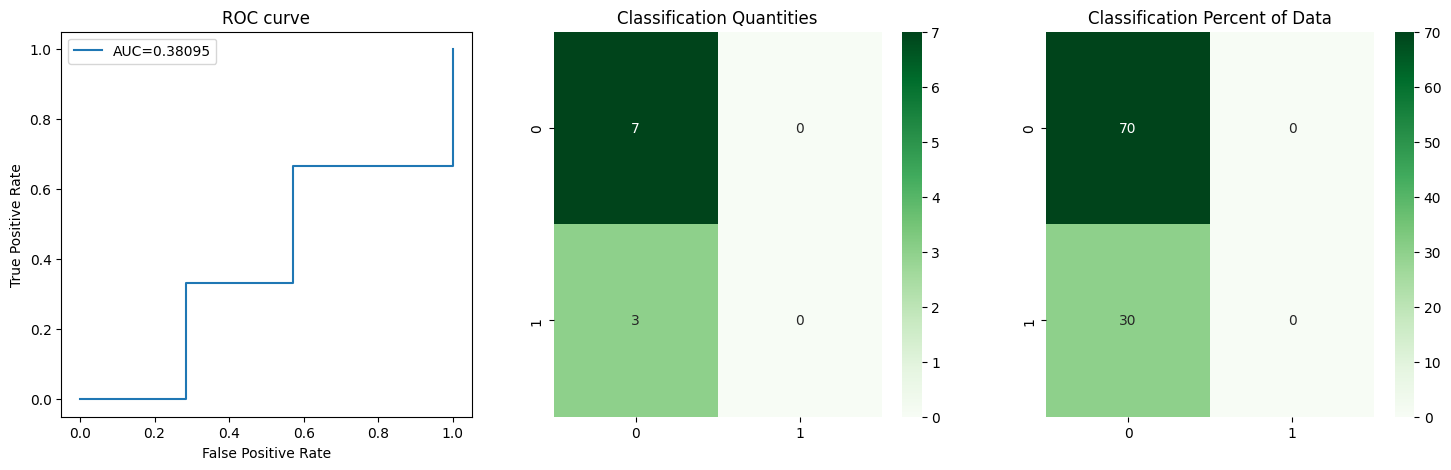

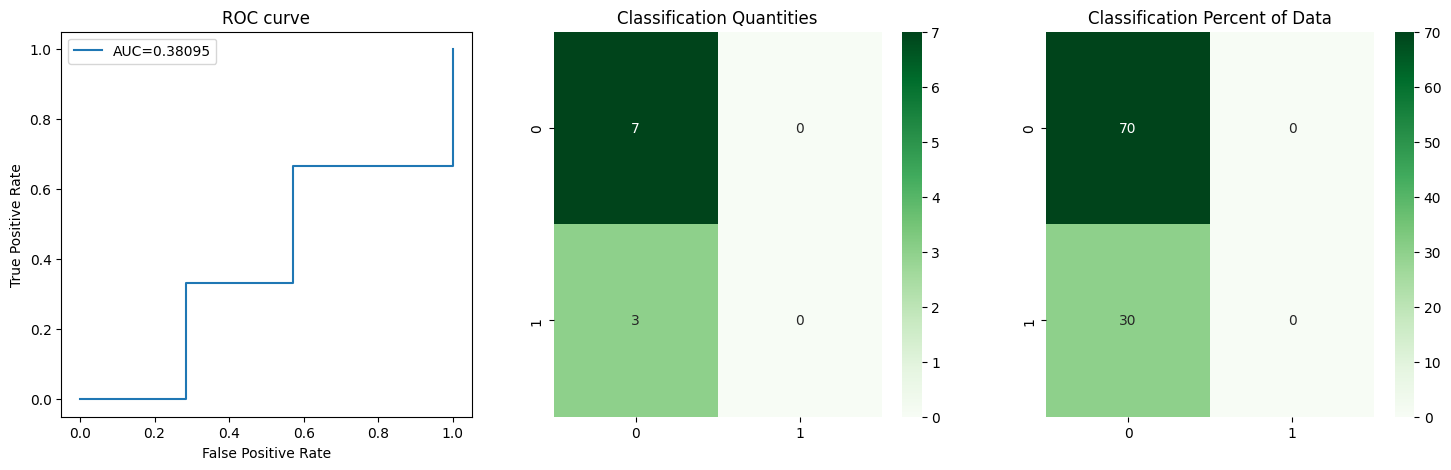

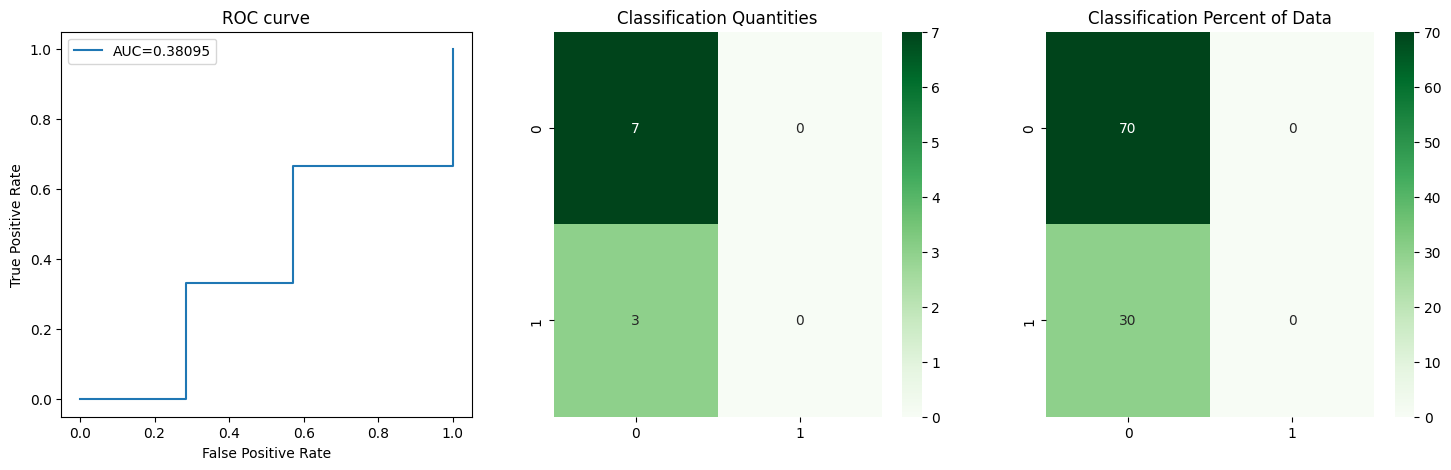

In [109]:
# Results for second dataset
print('Order of results:', model_names)
for i, tbl in enumerate(res_table_2.keys()):
    res_graphs(res_table_2[tbl])


Model Results on 3rd Dataset

Order of results: ['m1', 'm1_32', 'm1_64', 'm2', 'm2_32', 'm2_64', 'm3', 'm3_32', 'm3_64']


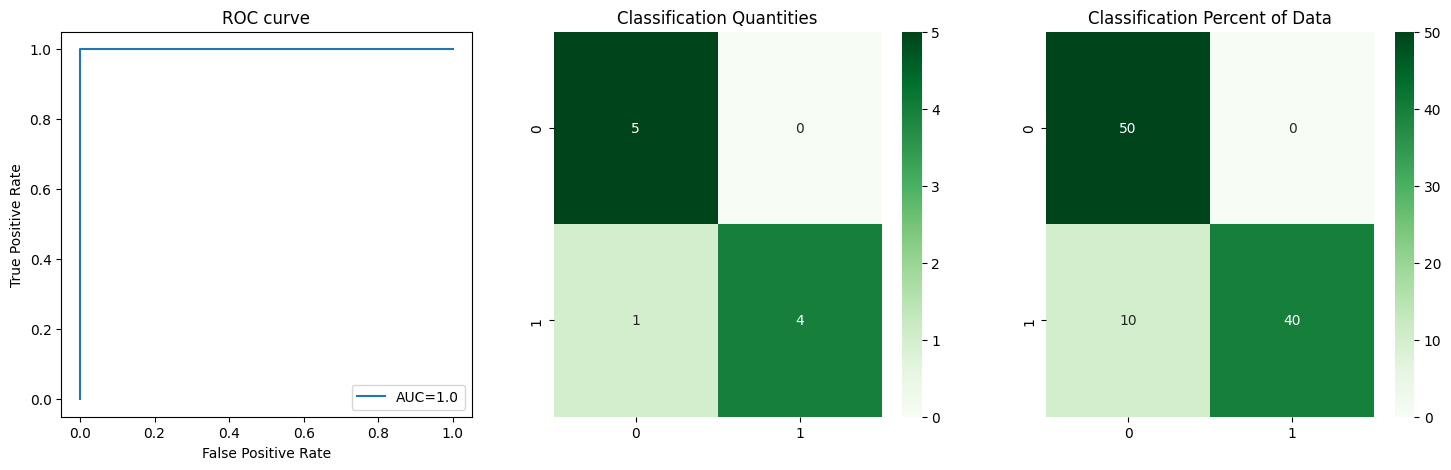

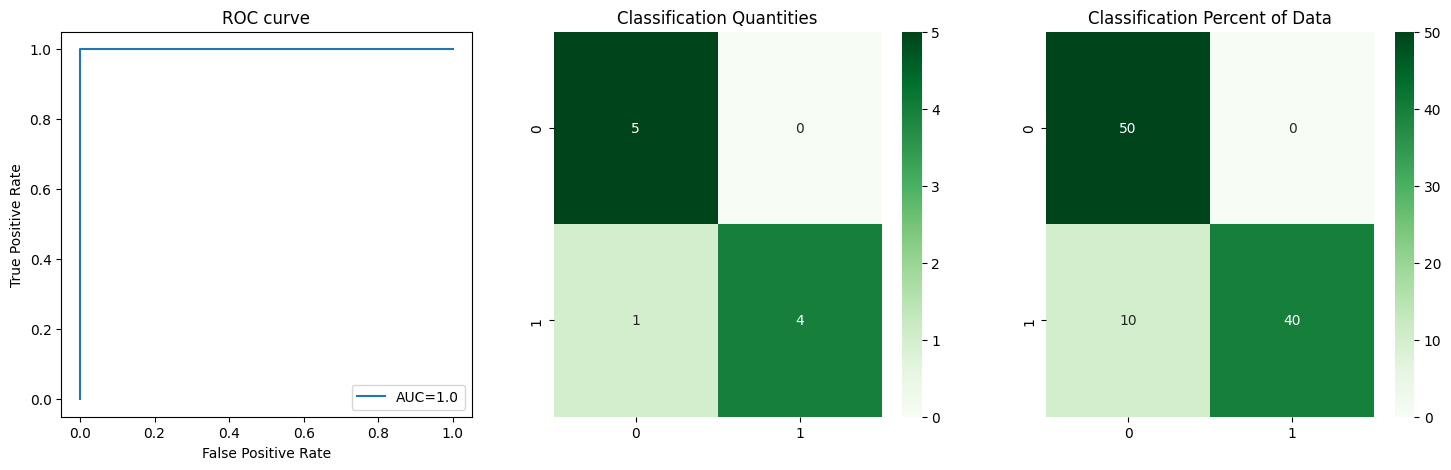

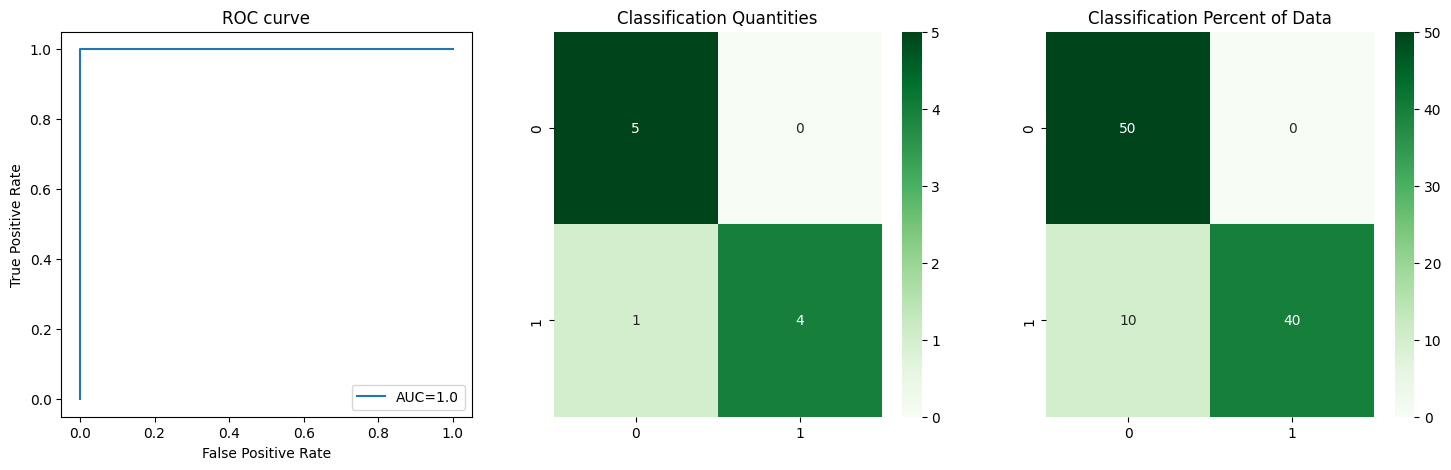

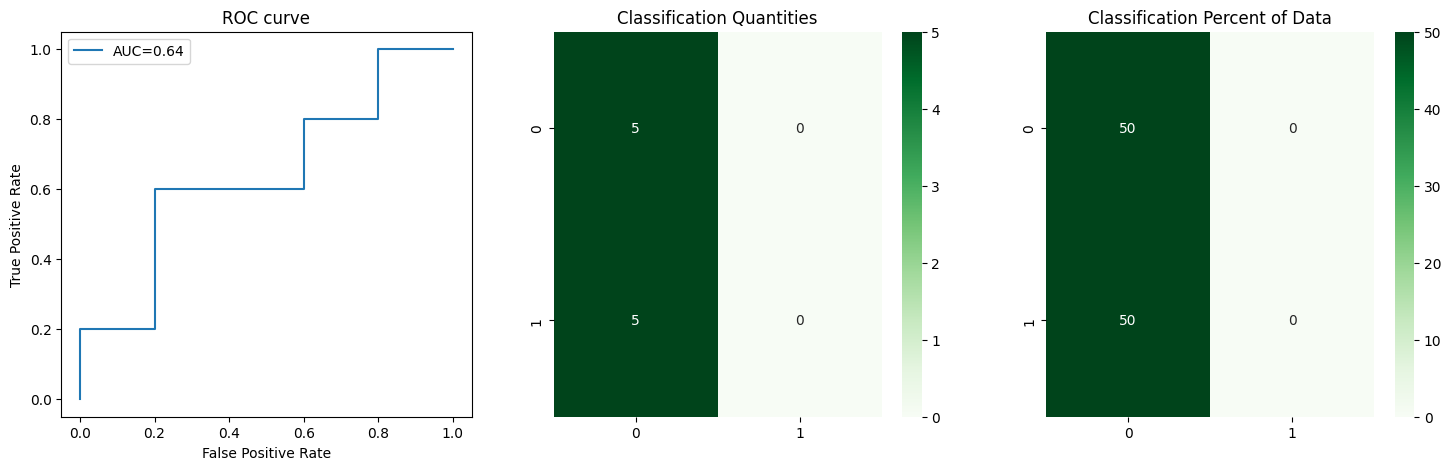

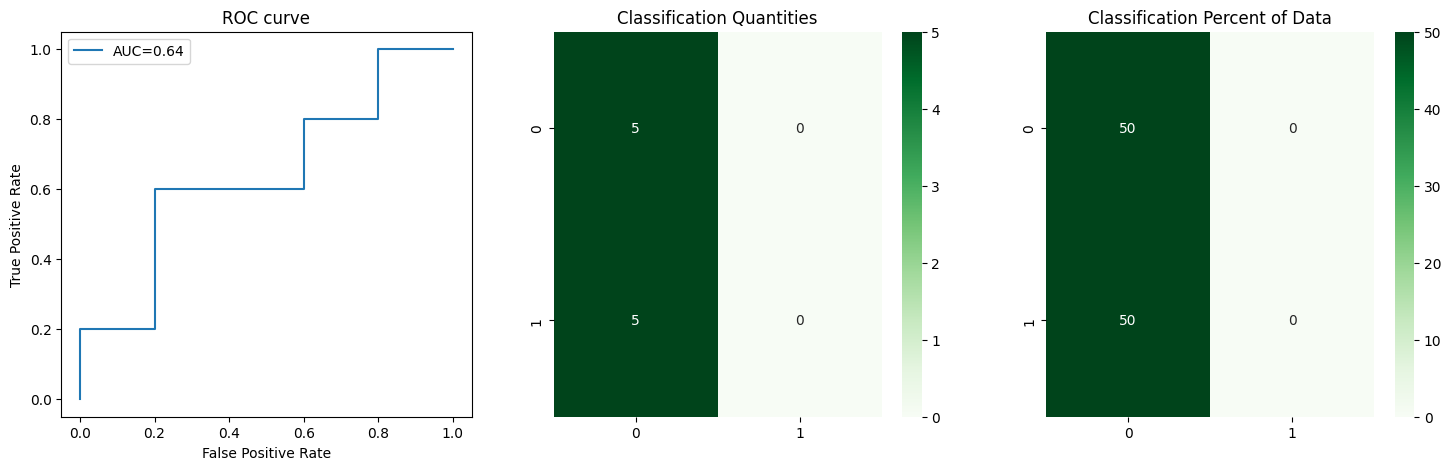

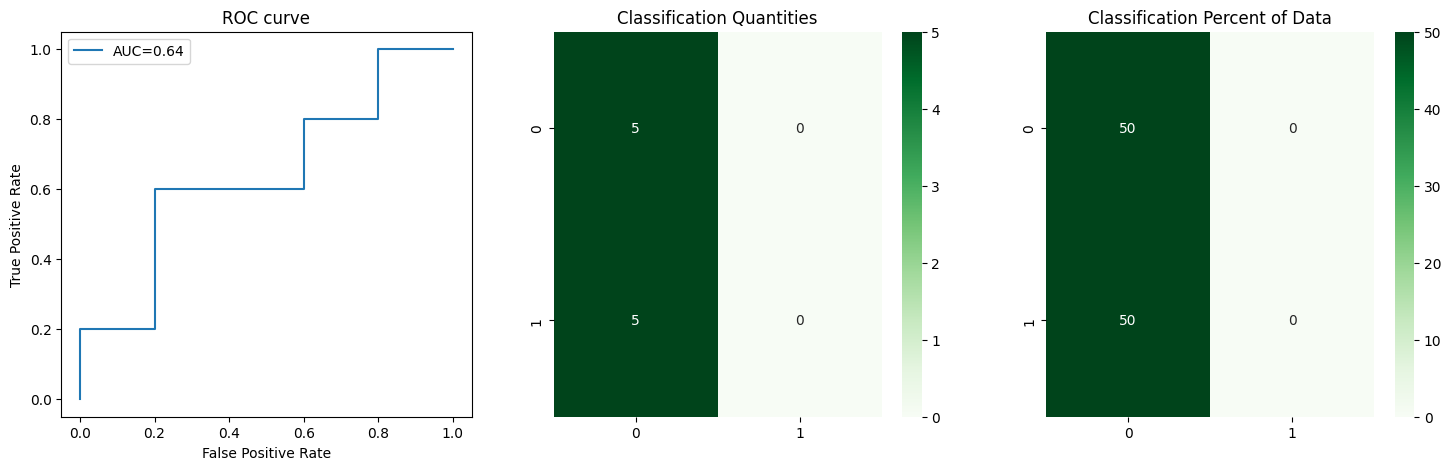

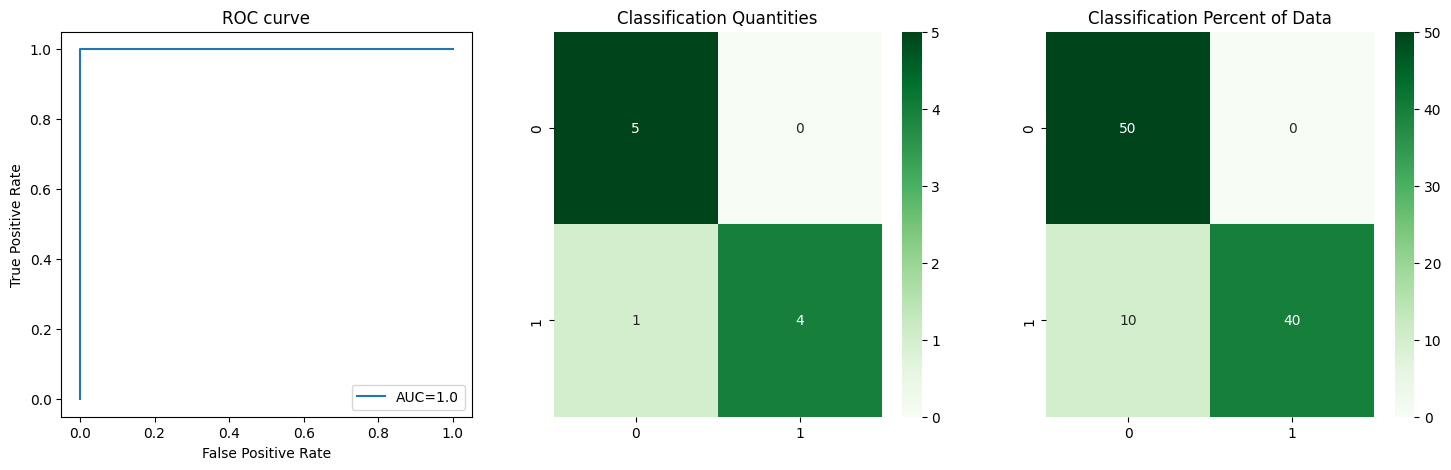

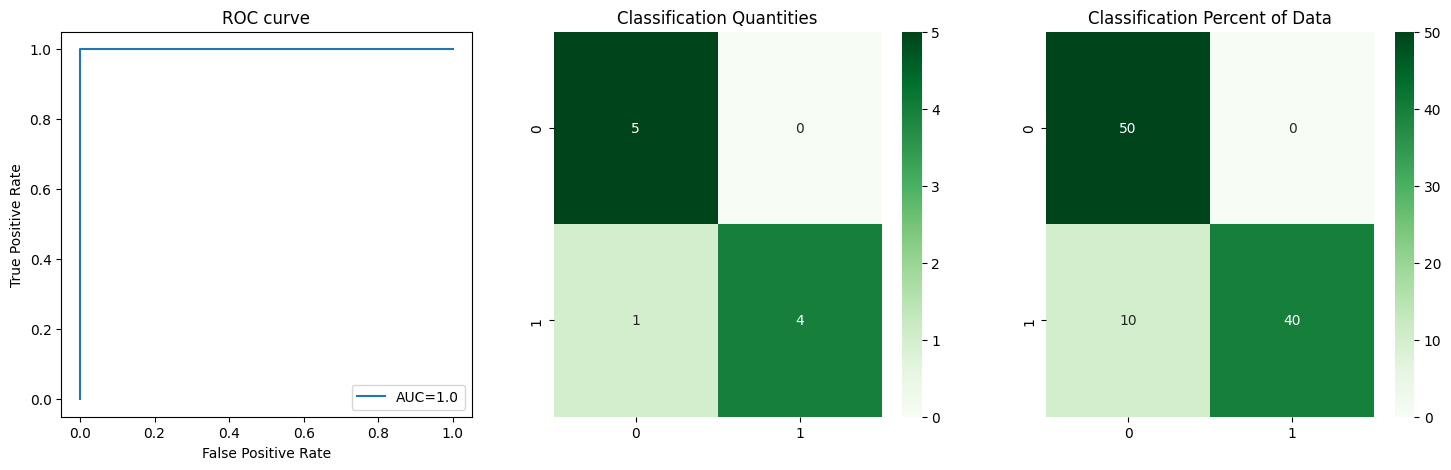

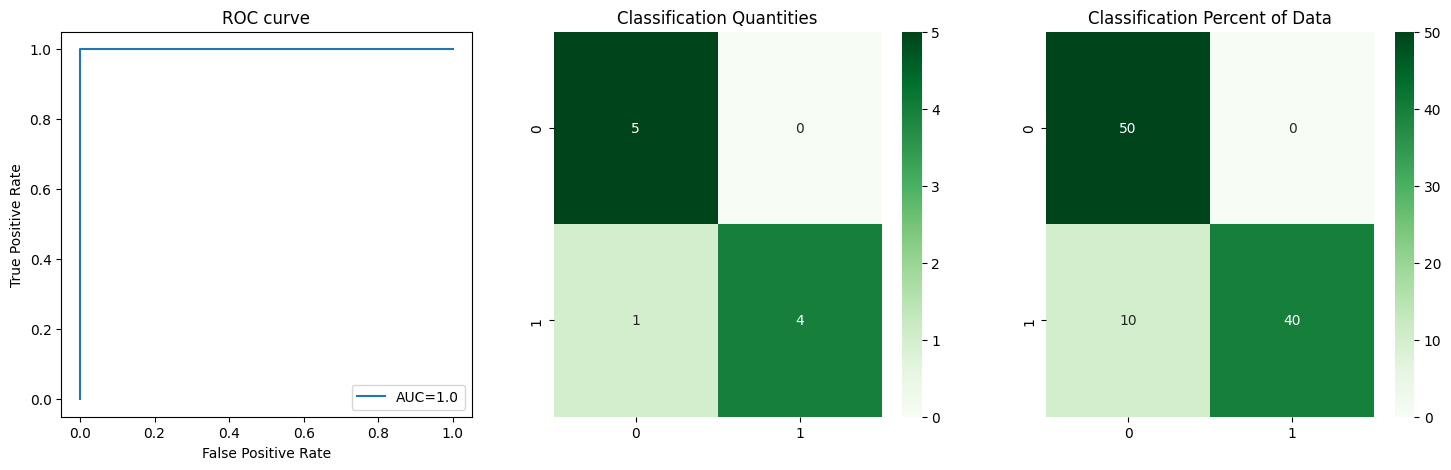

In [110]:
# Results for third dataset
print('Order of results:', model_names)
for i, tbl in enumerate(res_table_3.keys()):
    res_graphs(res_table_3[tbl])


Model Results on 4th Dataset

In [111]:
# Results for fourth dataset
print('Order of results:', model_names)
for i, tbl in enumerate(res_table_4.keys()):
    res_graphs(res_table_4[tbl])

Order of results: ['m1', 'm1_32', 'm1_64', 'm2', 'm2_32', 'm2_64', 'm3', 'm3_32', 'm3_64']


NameError: name 'res_table_4' is not defined

In [ ]:
# On Runpod GPU (1 x RTX 4000 Ada) --- memory constrains when inferring > 20,000 images
    # batching?
# 20,000 images in 160 seconds
# all images (179430) in x time